# AtLAST extragalactic observations

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [2]:
from maria import Simulation, mappers, TOD

In [3]:
from astropy.constants import c
from astropy import units as u

### Physical scaling

In [4]:
# Calculate observed frequency and channel width in GHz
def  skyfrq(line, z):
    return  line / (1 + z)

def widthfrq(frq, kms):
    return (kms/c_kms) * frq

In [5]:
# Fits Image details
resval  = 1024
simsize = 10000 # kpc
CII_frq = 1900.537 # GHz

# Fits vals
redshifts = [6.5,       6.0,        3.0,        1.0,    0.5,        0.02,   0.01]
DL        = [64739.8,   58985.0,    25924.2,    6701.1, 2863.0,     87.5,   43.4] # Mpc
scale     = [5.580,     5.836,      7.855,      8.122,  6.169,      0.408,  0.206] # kpc/"
c_kms     = 299792.458 # km s-1
channel   = 50 # km s-1

frq = skyfrq(CII_frq, 1.0)

width = widthfrq(frq,channel)
print(f'Frequency:         {frq} GHz')
print(f'Channel:           {width} GHz, ({channel} km s-1)')

size                = simsize / scale[3] / 3600 # deg 

pixel_size          = size / resval # deg
pointing_center     = (260.0, -10.0) #RA and Dec in degrees
integration_time    = 5 * 60.0 #seconds

scanning_speed      = 0.05 #deg/s
sample_rate         = 100 # float(int(225. * (scanning_speed/0.25) * (frq/92.0)**2))  #Hz
FOV                 = size/2 # deg
ndets               = int(int(3000 * (FOV/0.25)**2 * (frq/92.0)**2))

scanning_radius     = FOV/4 #deg
Beam_size           = ((1.22*c/(frq*u.GHz).to(1/u.s)/(50 * u.m))*u.rad).to(u.arcsec)

print(f'Size:              { size*3600} arcsec')
print(f'Beam Size:         {Beam_size}')
print(f'Pixel Size:        {pixel_size*3500} arcsec' )
print()
print(f'Scan velocity:     {scanning_speed*3600} arcsec/s')
print(f'Field of View:     {FOV*3500} arcsec' )
print(f'Scanning Radius:   {scanning_radius*3500} arcsec' )
print(f'# of Detectors:    {ndets}')
print(f'Sampling rate:     {sample_rate} Hz' )
print('-----------------------')

Frequency:         950.2685 GHz
Channel:           0.15848772619890258 GHz, (50 km s-1)
Size:              1231.2238364934744 arcsec
Beam Size:         1.5877763512465612 arcsec
Pixel Size:        1.1689679437193905 arcsec

Scan velocity:     180.0 arcsec/s
Field of View:     598.5115871843279 arcsec
Scanning Radius:   149.62789679608198 arcsec
# of Detectors:    149750
Sampling rate:     100 Hz
-----------------------


In [6]:
inputfile = "../../../maria/data/maps/galaxy.fits"

noisy = False

outfile_map = '/tmp/galaxy_{}min_noisy{}_map.fits'.format(
    int(integration_time/60),
    str(noisy)
)

if noisy:
    atm_model            = '2d'
    white_noise_level    = 0.
    pink_noise_level     = 0.
else:
    atm_model            = None
    white_noise_level    = 0.
    pink_noise_level     = 0.

In [7]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.constants import c

# - Input figure
cmap = "RdBu_r"

# - Input figure
hdu = fits.open(inputfile)
hdu[0].data = hdu[0].data
header = hdu[0].header

header['RESTFRQ'] = frq

header["CDELT1"] = pixel_size  # degree
header["CDELT2"] = pixel_size  # degree

header['CRPIX1'] = resval/2
header['CRPIX2'] = resval/2

header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "
header['RADESYS']= "FK5     "

header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]
wcs_input = WCS(header, naxis=2)

/Users/tom/opt/anaconda3/envs/maria/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


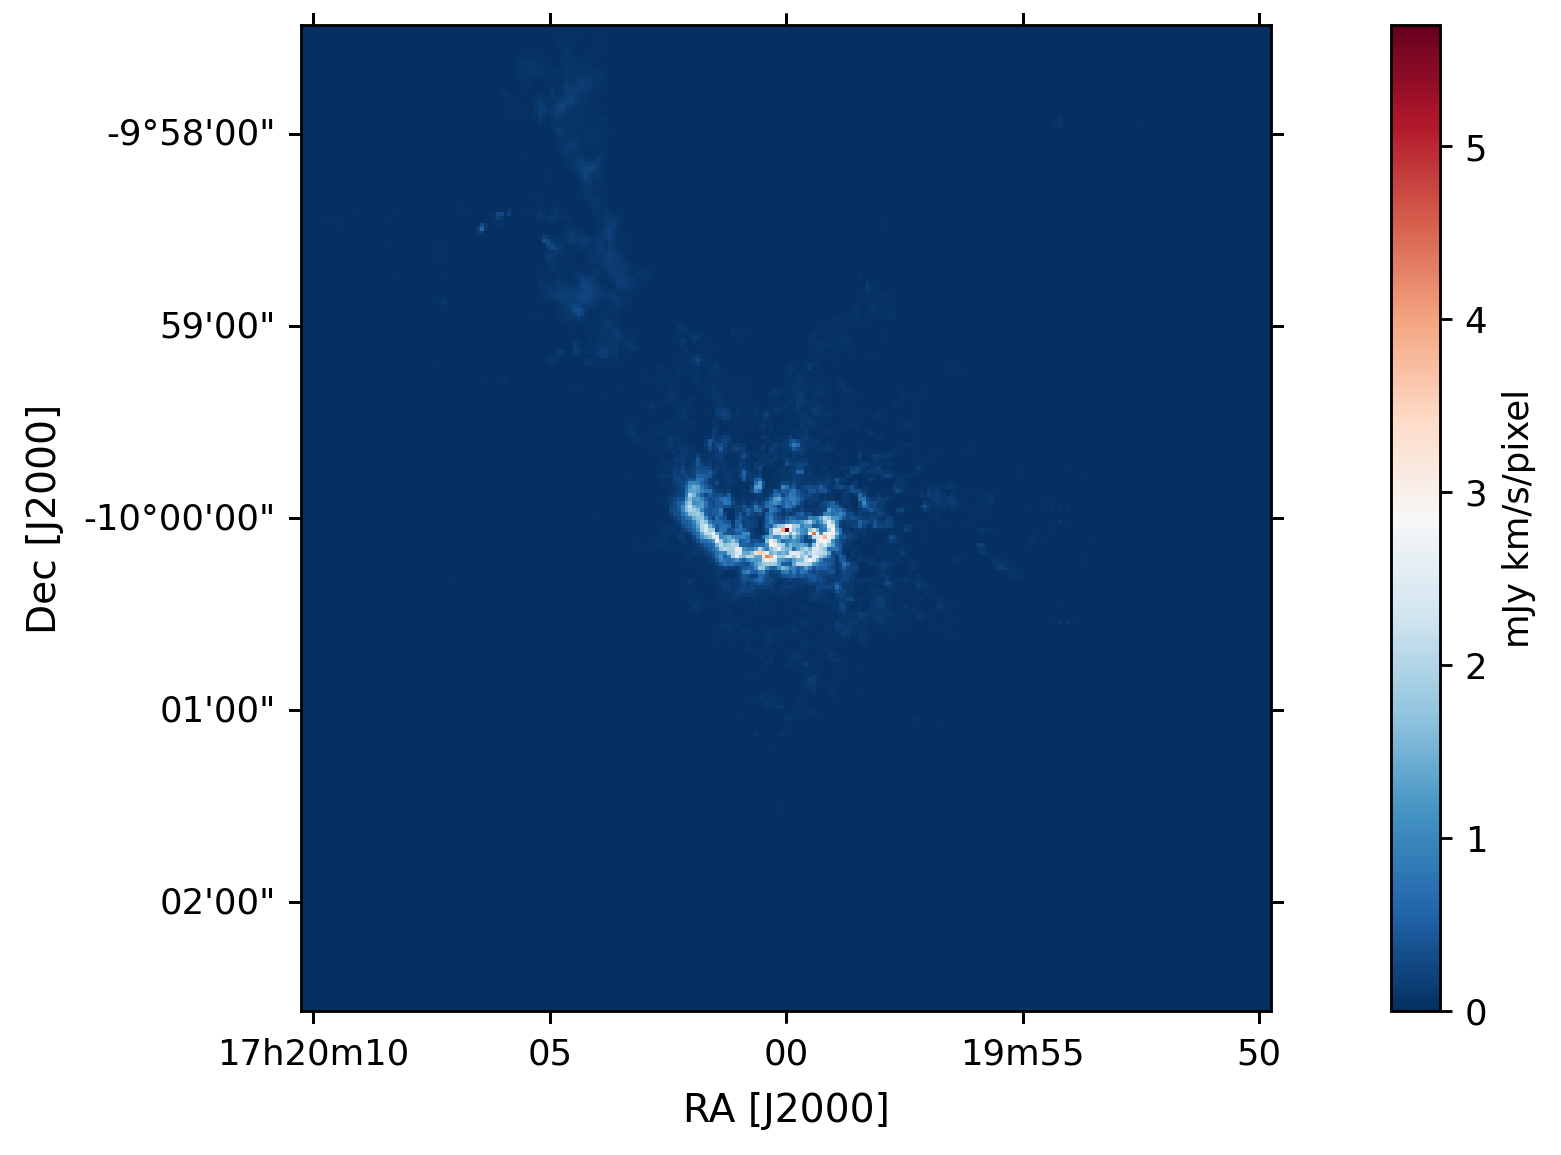

In [8]:
sky_l = SkyCoord((pointing_center[0] - FOV/4) * u.deg, (pointing_center[1] - FOV/4) * u.deg)
sky_u = SkyCoord((pointing_center[0] + FOV/4) * u.deg, (pointing_center[1] + FOV/4) * u.deg)

fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_input)

im = ax.imshow(hdu[0].data * 1e3, cmap=cmap)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label('mJy km/s/pixel')

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)
plt.show()

### Run the sim

In [9]:
sim = Simulation(

    # Mandatory minimal weather settings
    # ---------------------
    array    = "AtLAST",  # Array type
    pointing = "daisy",  # Scanning strategy
    site     = "llano_de_chajnantor",  # Site
 
    white_noise_level = white_noise_level,
    pink_noise_level  = pink_noise_level,
    
    # True sky input
    # ---------------------
    map_file     = inputfile,                # Input files must be a fits file.
    map_units    = 'Jy/pixel',               # Units of the input map in Kelvin Rayleigh-Jeans (K, default) or Jy/pixel
    map_res      = pixel_size,               # degree, overwrite header information
    map_center   = pointing_center,          # RA & Dec in degree
    map_freqs    = [frq],

    # AtLAST Observational setup
    # ----------------------------
    integration_time = integration_time,  # Seconds
    sample_rate      = sample_rate,       # Hz
    scan_center      = pointing_center,   # Degrees
    start_time       = "2022-08-01T23:00:00",

    field_of_view    = FOV,
    detector_config  = {"f950": {"n": 1500, "band_center": frq, "band_width": width}},
    scan_options     = {"speed": scanning_speed, "radius": scanning_radius, "petals": 2.11, "miss_factor": 0.05},
    verbose=True
)

Initializing atmosphere


In [10]:
tod = sim.run()

Sampling atmosphere for band f950: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


ran atmospheric simulation in 20.8 seconds


Sampling map at 950.2685 GHz: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.01s/it]


### Visualizing the TOD Data

In this section, we present the same array and TOD visualizations as in the MUSTANG-2 case, but this time for AtLAST:

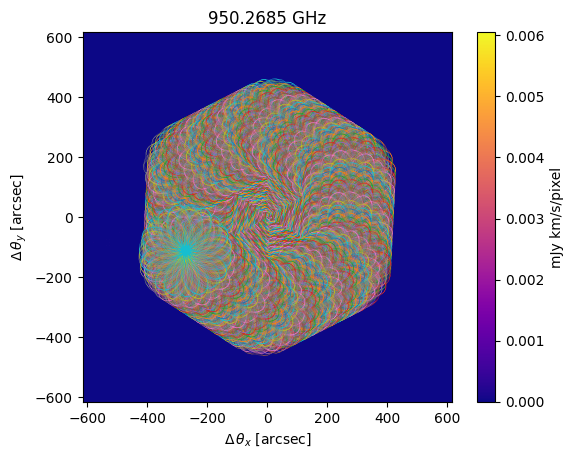

In [11]:
sim.input_map.plot(units='arcsec')

dx, dy = tod.coords.offsets(frame=sim.input_map.frame, center=sim.input_map.center, units='arcsec')

plt.plot(dx.T, dy.T, lw=1e-1)
plt.show()

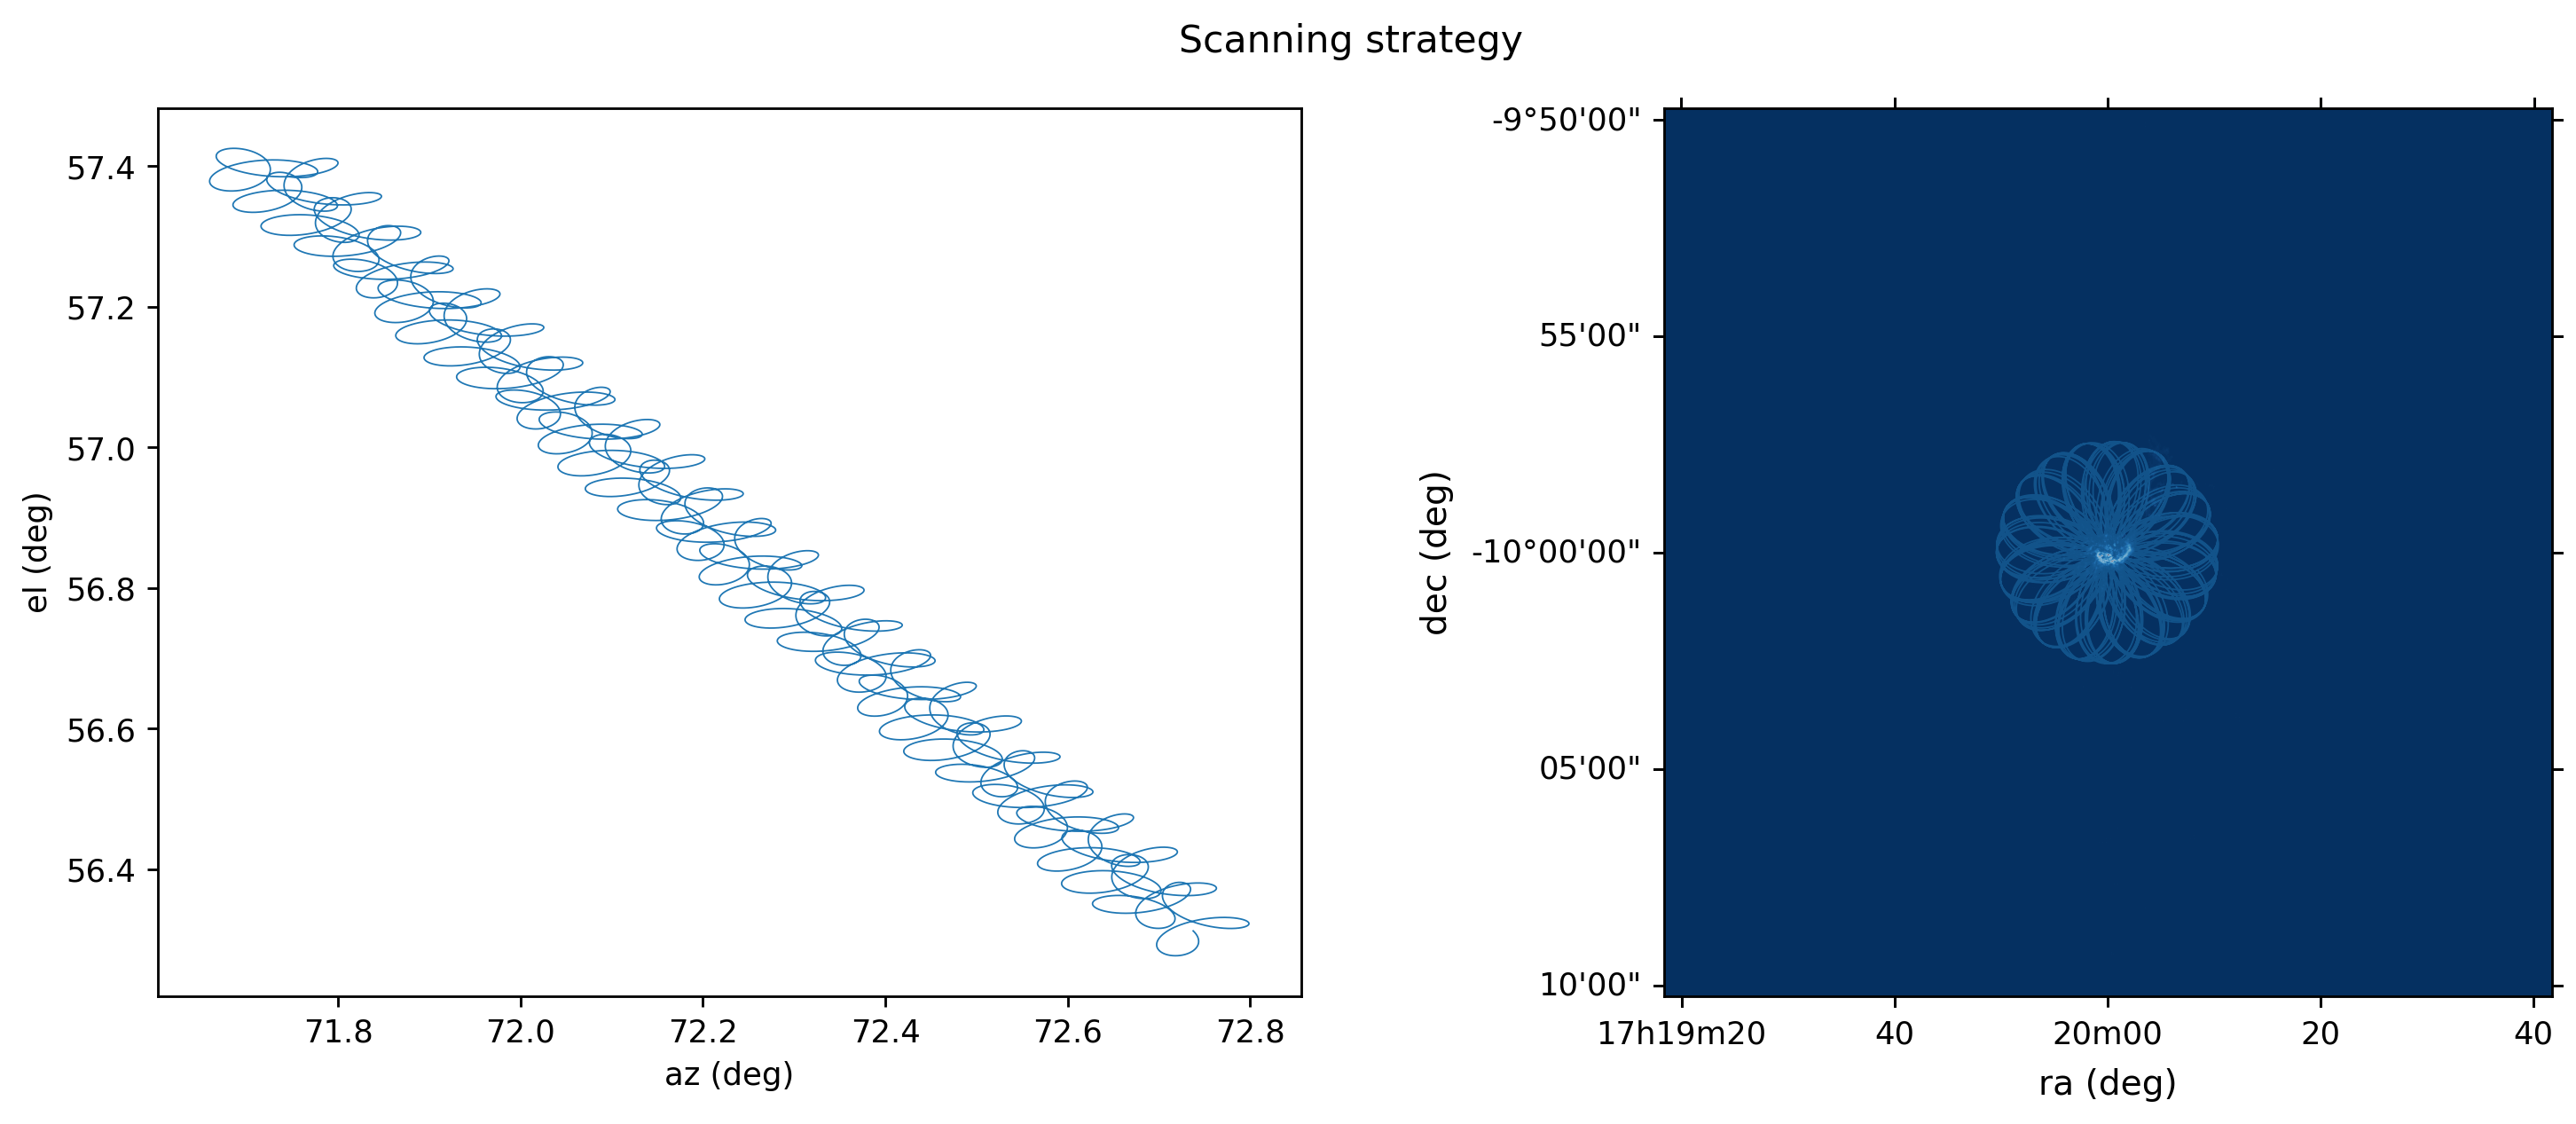

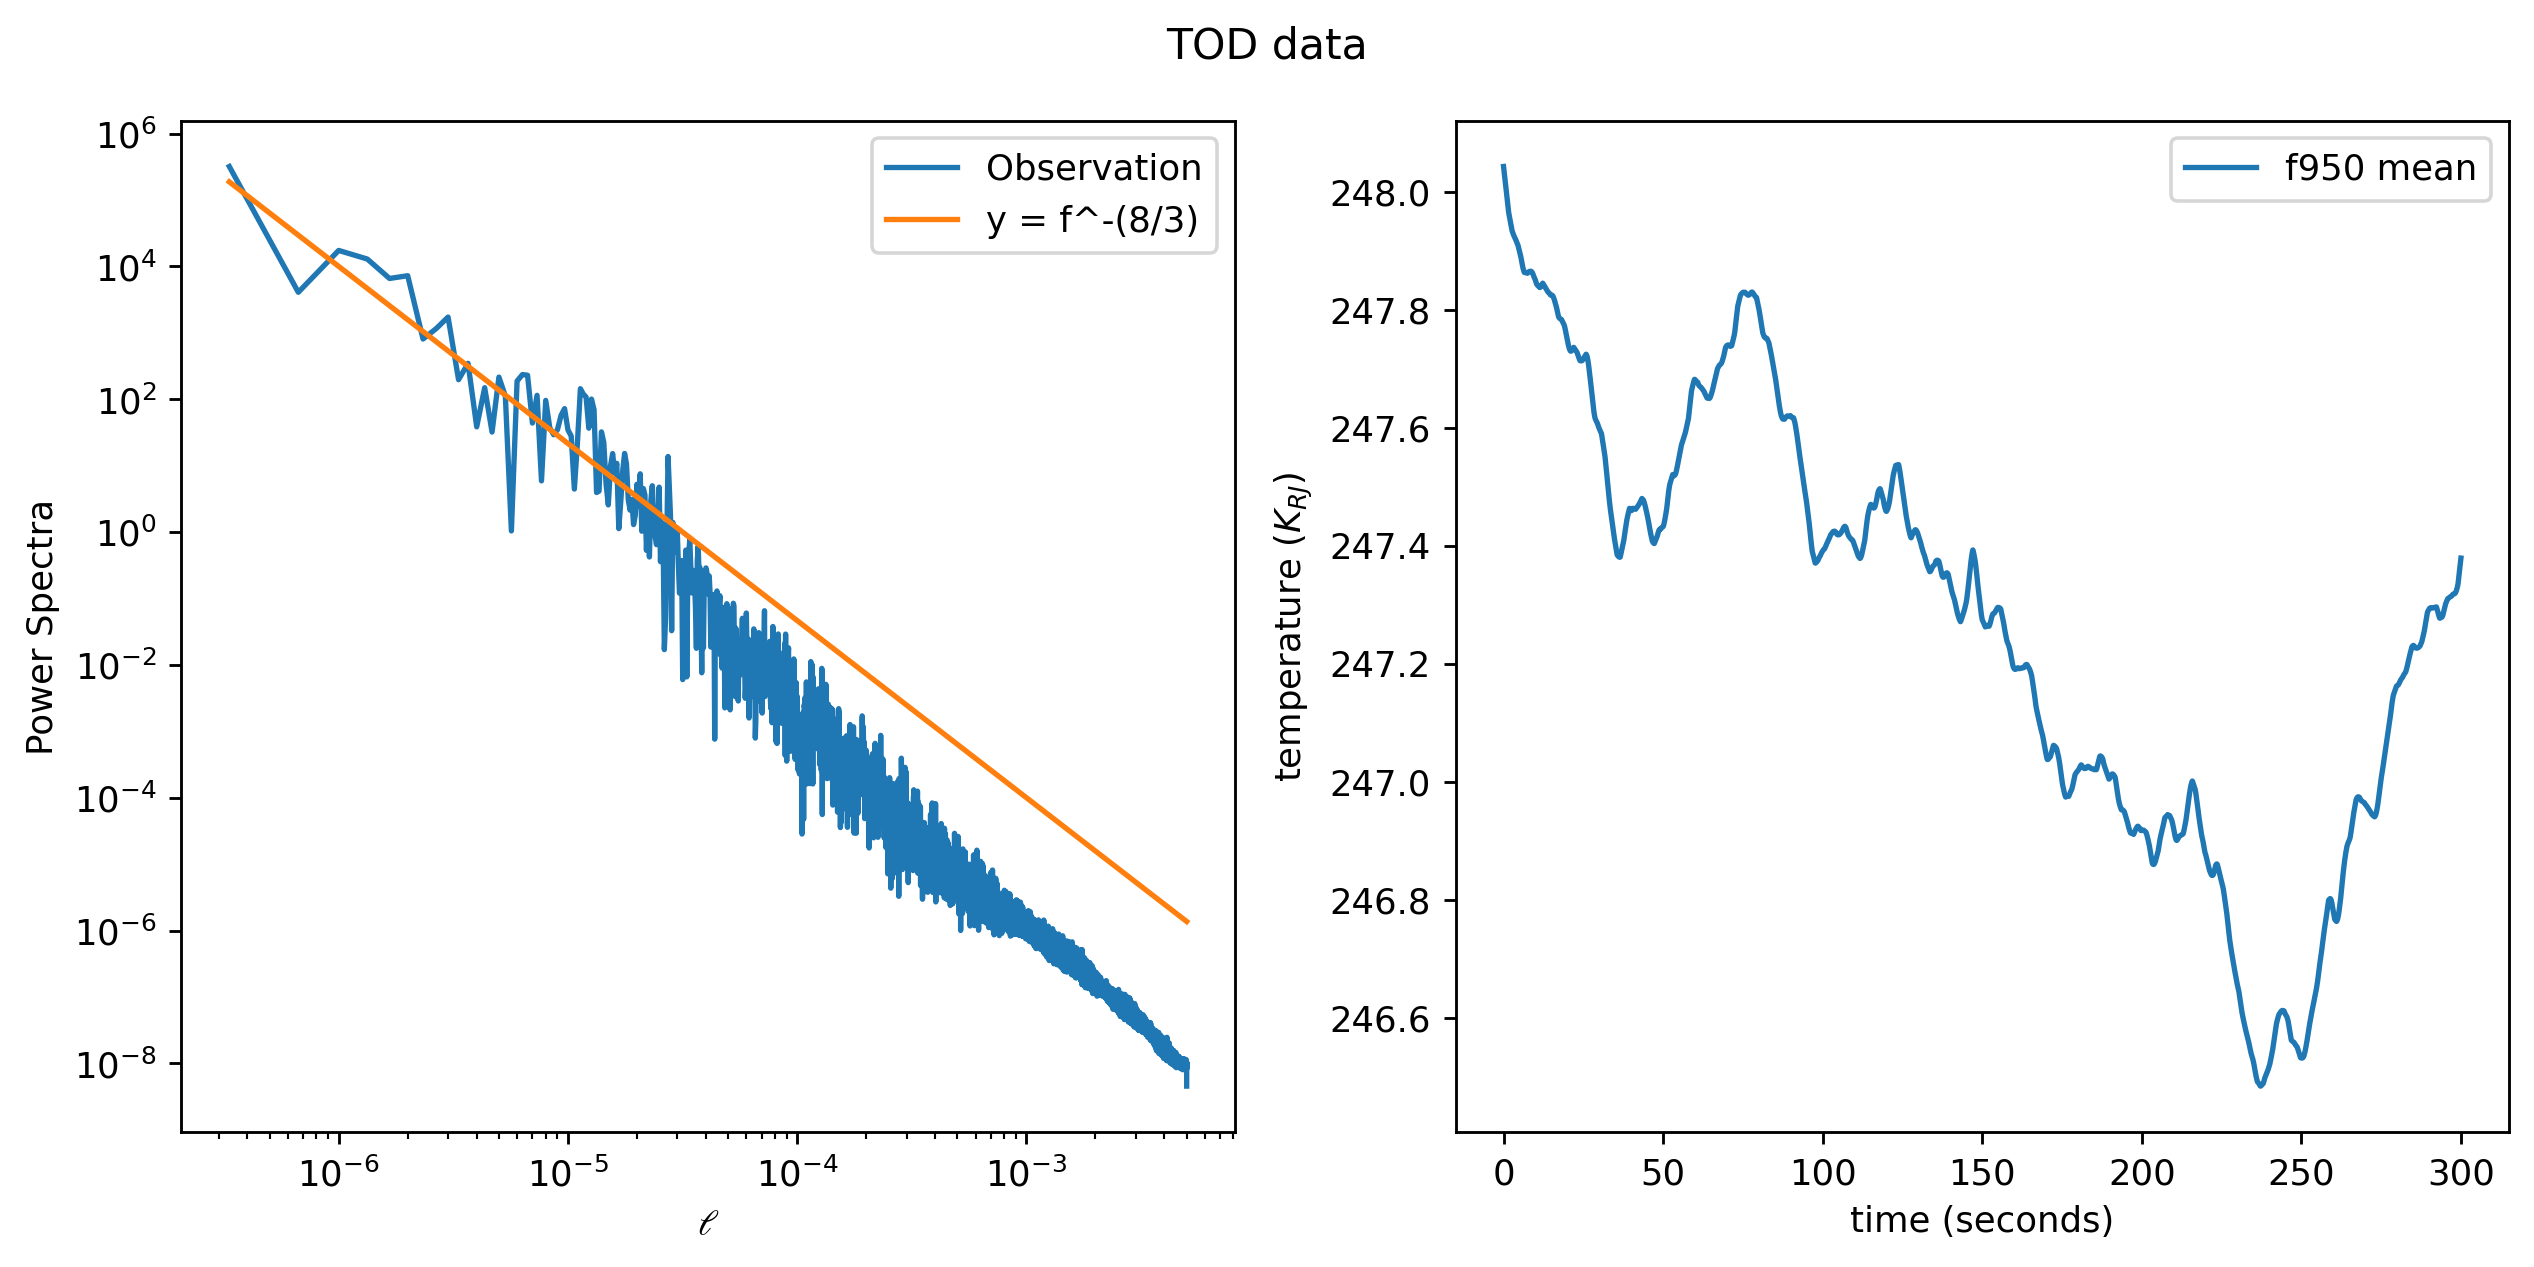

In [12]:
# visualize scanning patern
# -----------------------
cmap = "RdBu_r"

fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(1, 2, 1)

ax.plot(np.degrees(tod.boresight.az), np.degrees(tod.boresight.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[0].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.boresight.ra) * u.deg, np.degrees(tod.boresight.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5)
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1] - tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle("TOD data")
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], 1e-12 * f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time - tod.time[0], band_mean, label=f"{uband} mean")

axes[1].set_xlabel("time (seconds)"), axes[1].set_ylabel(r"temperature ($K_{RJ}$)")
axes[1].legend()

plt.show()

### Map-Making

As previously mentioned, we must disable Fourier filtering. Additionally, we have adjusted the height and width of the map to match the realistic AtLAST field of view, which spans several degrees.

In [13]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(tod.boresight.center_ra, tod.boresight.center_dec), 
                   frame="ra_dec", 
                   width=np.radians(FOV),
                   height=np.radians(FOV),
                   res=4*np.radians(pixel_size),
                   filter_data=True,
                   n_modes_to_remove=1,
                   degrees = False,
                   map_smooth = Beam_size.value #arcsec
                  )

mapper.add_tods(tod)
mapper.run()

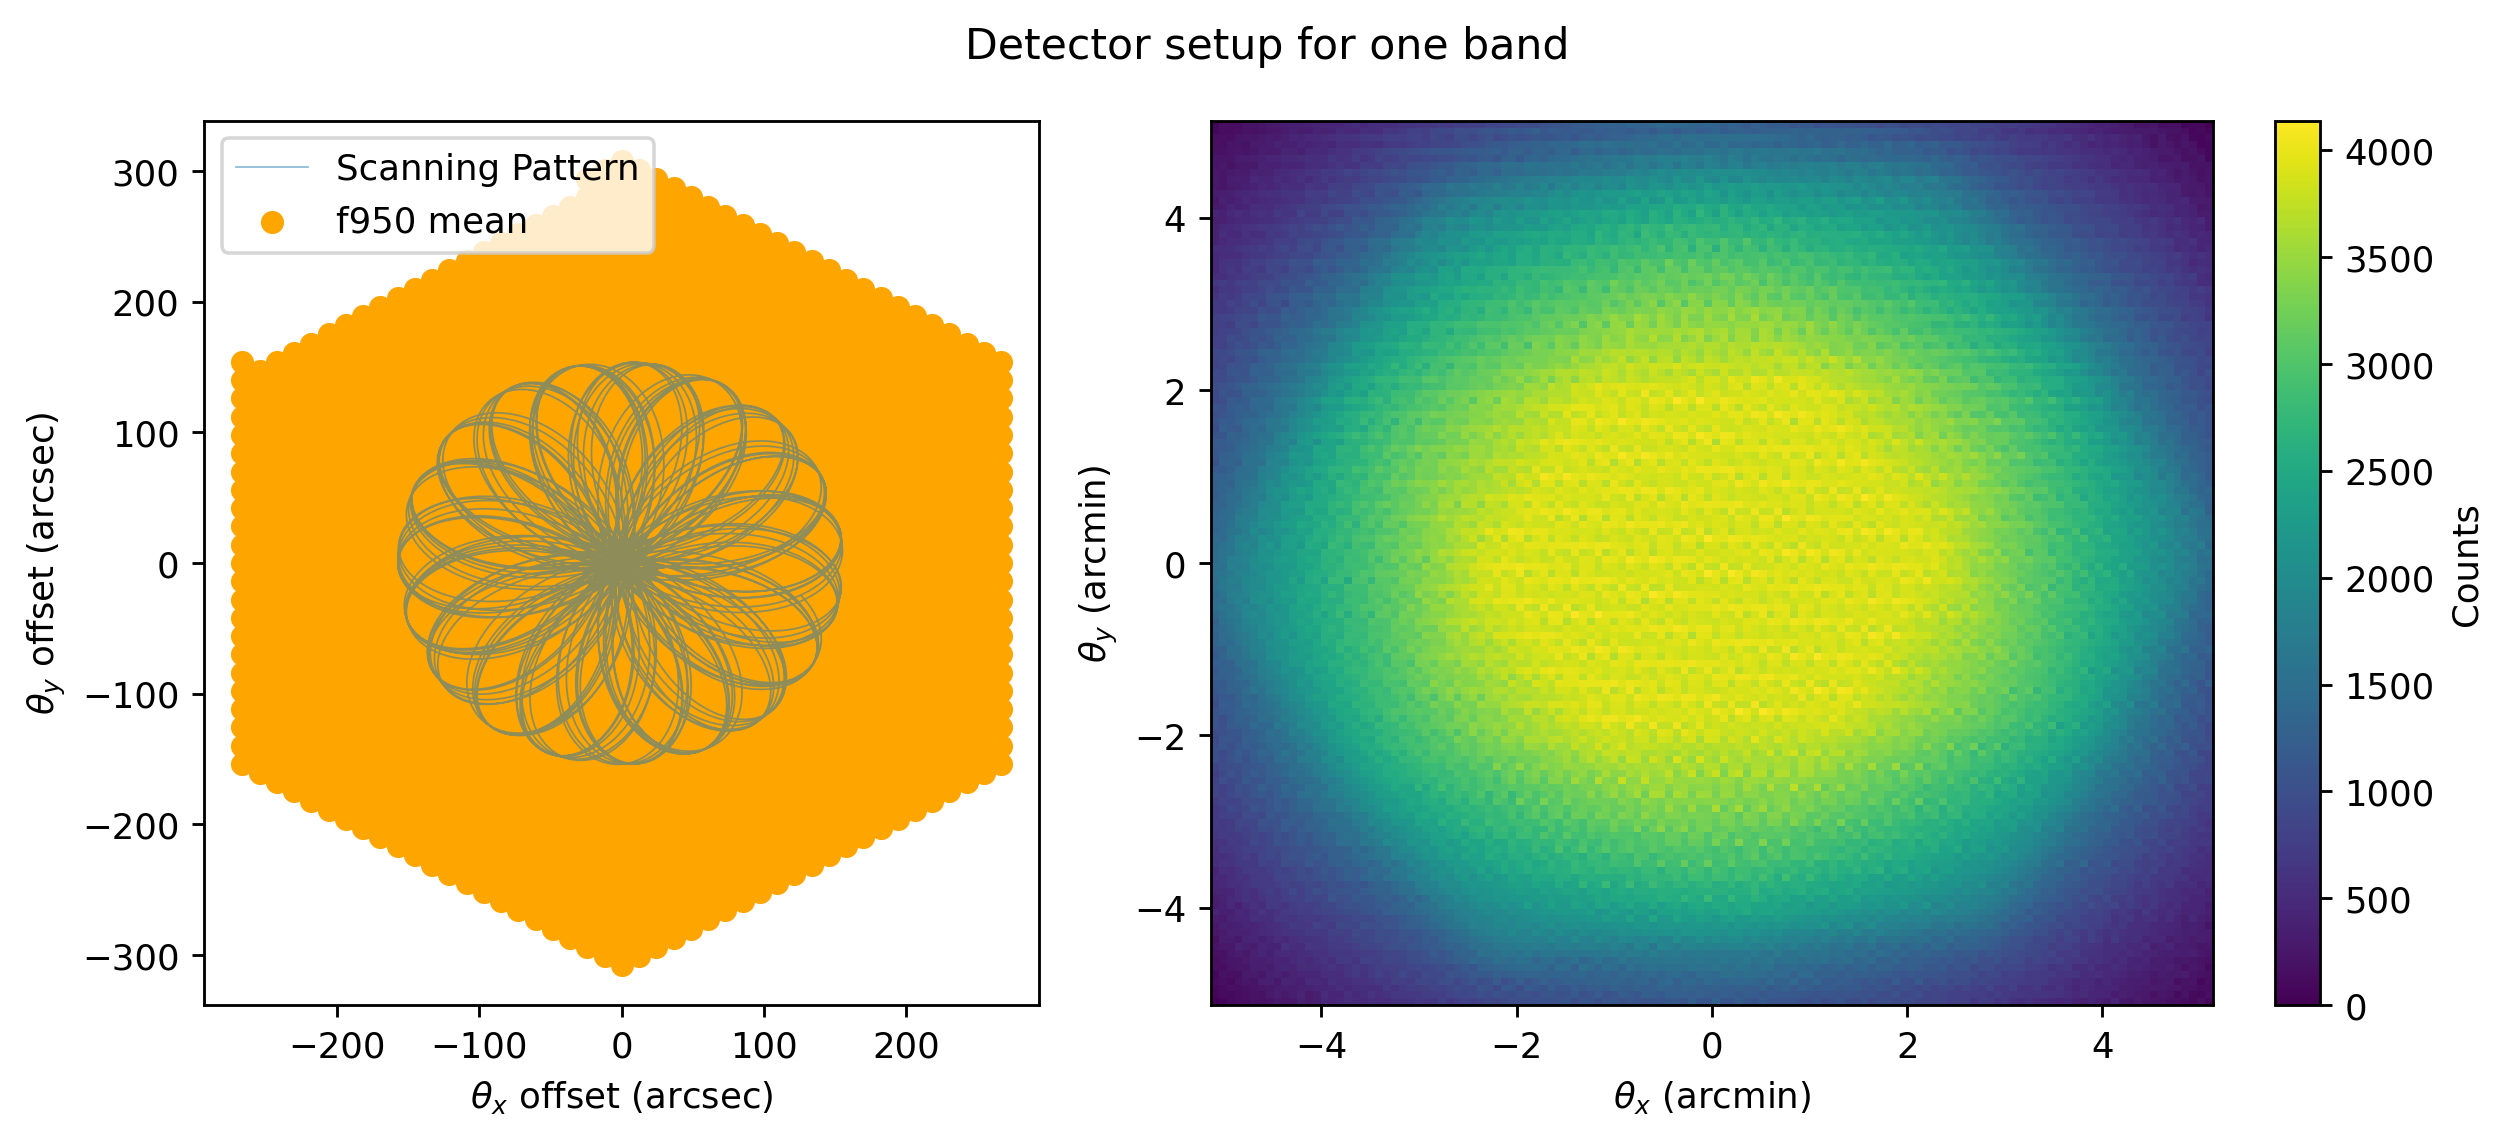

In [14]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.array.ubands:
    band_mask = sim.array.dets.band == uband

    axes[0].plot(
        3600 * np.degrees(tod.boresight.ra - tod.boresight.ra.mean()),
        3600 * np.degrees(tod.boresight.dec - tod.boresight.dec.mean()),
        lw=5e-1,
        alpha=0.5,
        label="Scanning Pattern",
    )
    axes[0].scatter(
        3600 * np.degrees(sim.array.offset_x[band_mask]),
        3600 * np.degrees(sim.array.offset_y[band_mask]),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )

axes[0].set_xlabel(r"$\theta_x$ offset (arcsec)")
axes[0].set_ylabel(r"$\theta_y$ offset (arcsec)")
axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

im = axes[1].pcolormesh(
    xs,
    ys,
    mapper.map_cnts[tod.dets.band[0]],
    label="Photon counts in band " + tod.dets.band[0],
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")
plt.show()

### Save & Visualize

In [15]:
mapper.save_maps(outfile_map)

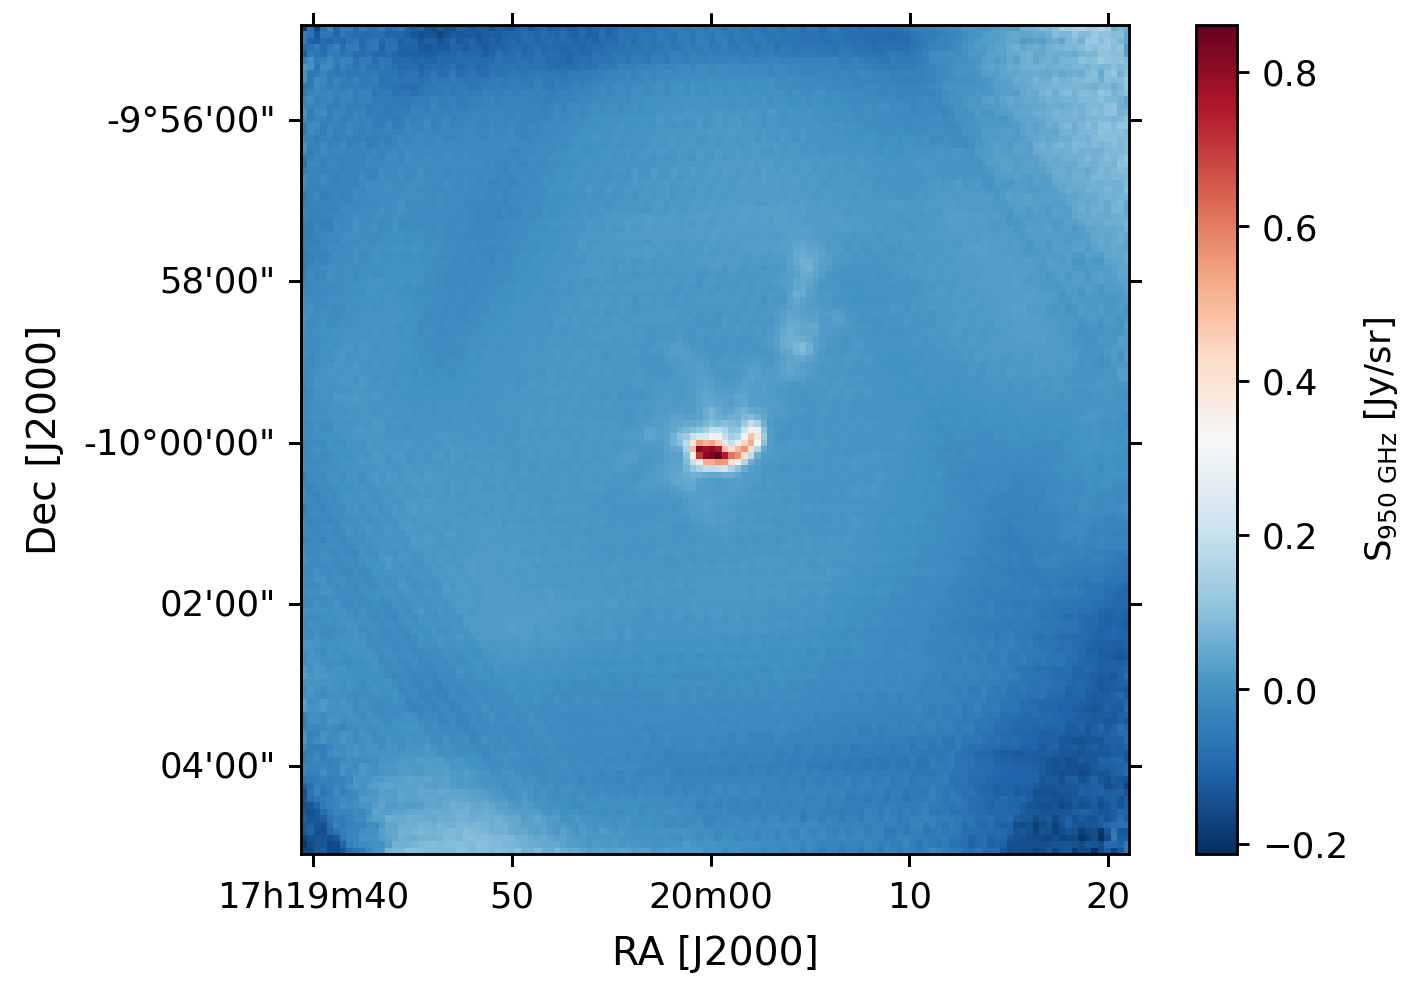

In [16]:

# - Plot Mock observation
outputfile = outfile_map

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

# - Plot
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

ax = plt.subplot(1, 1, 1, projection=wcs_output)
im = ax.imshow(hdu_out[0].data[0]*1e3, cmap='RdBu_r')
# im = ax.imshow(hdu_out[0].data[0]/(mapper.map_res**2)/1e6, cmap=cmap, vmin=-0.1, vmax=0.1)

cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label(r"S$_{950~\rm GHz}$ [Jy/sr]")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))


sky_l = SkyCoord((pointing_center[0] - 2) * u.deg, (pointing_center[1] - 2) * u.deg)
sky_u = SkyCoord((pointing_center[0] + 2) * u.deg, (pointing_center[1] + 2) * u.deg)

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)

plt.show()